In [5]:
import numpy as np

from ffnavpy.satellite import Satellite, OBC

import matplotlib.pyplot as plt

from ffnavpy.simulator import Simulator
from ffnavpy.simcase import ChiefDeputyCase
import control as ct

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
0.00011945855280557168 * 5022662.55457278

600.0

In [19]:
A = np.array([[1.1269, -0.4940, 0.1129], [1.0000, 0, 0], [0, 1.0000, 0]])

B = np.array([-0.3832, 0.5919, 0.5191]).reshape(-1, 1)

C = np.array([[1, 0, 0]])

np.linalg.matrix_rank(ct.ctrb(A, B))

3

In [20]:
np.linalg.eig(A)

(array([0.62579384+0.j        , 0.25055308+0.34297814j,
        0.25055308-0.34297814j]),
 array([[ 0.31506545+0.j        , -0.04980928+0.15605336j,
         -0.04980928-0.15605336j],
        [ 0.50346525+0.j        ,  0.22749754+0.31141777j,
          0.22749754-0.31141777j],
        [ 0.80452253+0.j        ,  0.9079814 +0.j        ,
          0.9079814 -0.j        ]]))

In [23]:
# Initial state of deputy [km, km/s]

x0 = np.array(
    [
        1.5097937630e11,
        -4.6840029080e-08,
        1.8369701987e-08,
        -6.0196990433e-15,
        1.5667113355e02,
        -1.1858897424e02,
    ]
)  # [m / m/s], 'P1-IdealSynodic', Sun-Earth

# x0 = np.array([ 1.51287312e+08,  0.00000000e+00, -7.70118240e+04,  2.38772827e-14,
#        -2.68181170e-01,  0.00000000e+00])

# Initial relative state [km, km/s]
dx0 = np.array([0.110, 0.09, 0.105, 1e-6, 0.00001, 0.000020])*1000

# Initial state chief [km, km/s]
x0_cs = x0 + dx0

# State commanded
x_target = np.array([100, 100, 100, 0, 0, 0])

# Duration of the simulation [s]
tf = 3600*1.5

# Time step of simulation [s]
dT = 1

# Create satellites with their corresponding initial states
LiteBird = Satellite(x0,1,70)
CalSat = Satellite(x0_cs,1,7)

# OBC config
t_star = OBC.DefConfigOBC.ts

ConfigOBC = {'x_target': x_target, 
             'estimation_mode': 'kalman',
             'control_mode': 'MPC',
             'Tsk': 1,
             'sigma_r0': 1e-7,
             'sigma_v0': 1e-8,
             'sigma_x': 1e-4,
             'sigma_y': 1e-4,
             'sigma_z': 1e-4,
             'period': 100,
             'horizon': 20,
             'u_threshold_v': np.ones(3) * 0.01,
             'x_threshold': np.concatenate([0.1*np.ones(3),0.001*np.ones(3)])
             }

configSim = {'sigma_distance': 1e-06, 'sigma_angle': 0.25}

# cmd_sequence = CommandSequence()
# cmd_sequence.add_command('change_control_mode', 'simple', 1000)
# cmd_sequence.add_command('change_estimation_mode', 'kalman', 3000)
# cmd_sequence.add_command('change_control_mode', 'LQR', 4800)
# cmd_sequence.add_command('change_control_mode', 'ETM', 3600*2)

# Create predefined case for chief-deputy formation
# simcase = ChiefDeputyCase(LiteBird, CalSat, cmd_sequence=cmd_sequence, configOBC=ConfigOBC)
simcase = ChiefDeputyCase(LiteBird, CalSat, configOBC=ConfigOBC)
sim = Simulator(simcase, dT)


# Simulate
sim.simulate(tf)

100%|██████████| 5401/5401 [00:21<00:00, 248.71it/s]


0

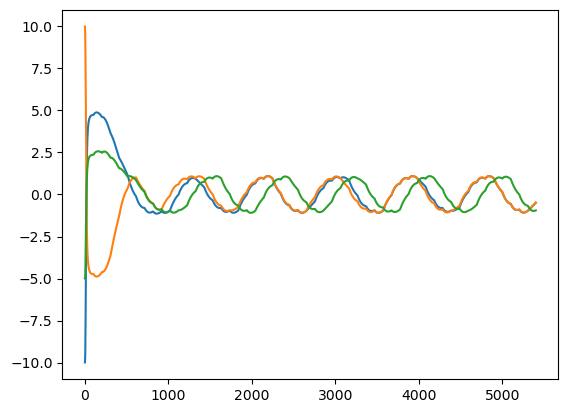

In [29]:
plt.plot(sim.report.x_estimated[0:3].T - sim.report.relative_state[0:3].T)

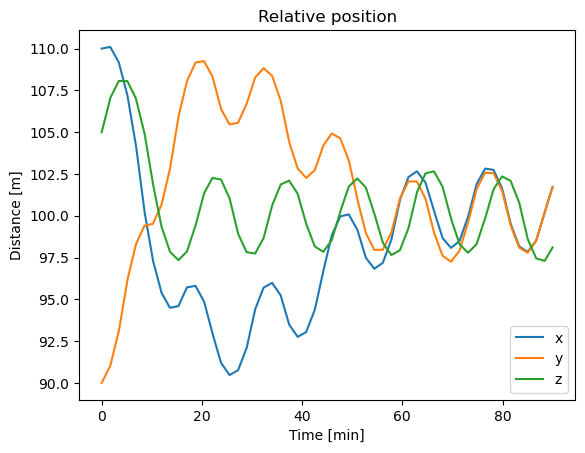

In [30]:
plt.plot(sim.report.time/60,sim.report.relative_state[:3].T)

plt.title('Relative position')
plt.xlabel('Time [min]')
plt.ylabel('Distance [m]')
# plt.vlines([1000/60, 4800/60], 90, 115, colors='k', linestyles='dotted')
# plt.hlines(100,sim.simcase.deputy.trajectory.time[0]/60, sim.simcase.deputy.trajectory.time[-1]/60, colors='k', linewidth=0.5)
# plt.text(-3, 115, 'No control')
# plt.text(42, 115, 'P control')
# plt.text(95, 115, 'LQR')
plt.legend(['x', 'y', 'z'],loc=4)
# plt.savefig('position')

In [31]:
sim.report.relative_state[:3,-1].T

array([101.72659302, 101.72893957,  98.10734118])

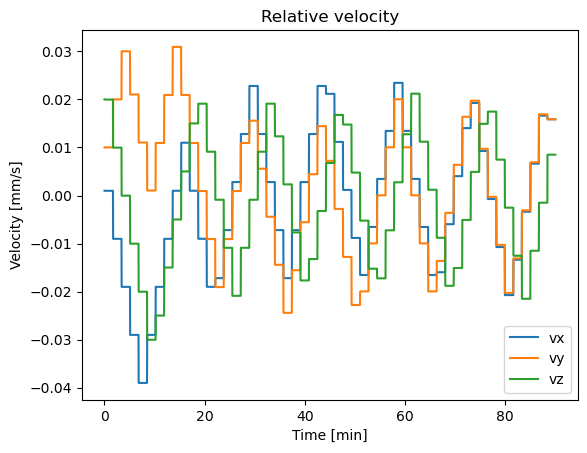

In [32]:
plt.plot(sim.report.time/60,sim.report.relative_state[3:].T)
plt.title('Relative velocity')
plt.xlabel('Time [min]')
plt.ylabel('Velocity [mm/s]')
# plt.vlines([1000/60, 4800/60], -15, 25, colors='k', linestyles='dotted')
# plt.text(-3, 25, 'No control')
# plt.text(42, 25, 'P control')
# plt.text(95, 25, 'LQR')
plt.legend(['vx', 'vy', 'vz'], loc=4)
# plt.savefig('velocity')

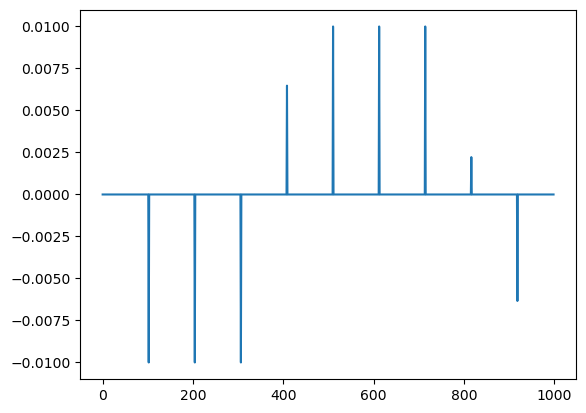

In [17]:
plt.plot(np.diff(sim.report.relative_state[3,:1000].T))

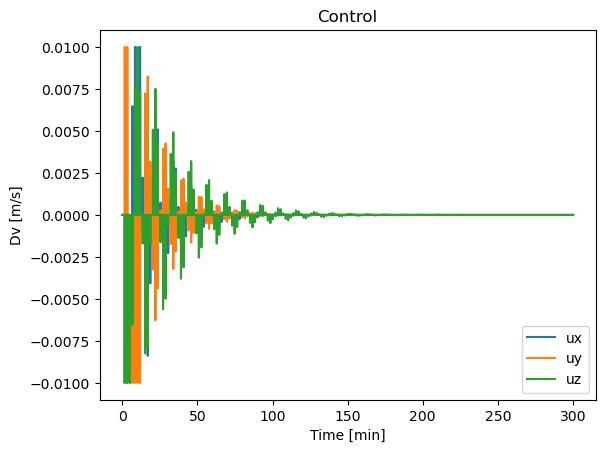

In [18]:
plt.plot(sim.simcase.deputy.trajectory.time/60,sim.simcase.report.u_cmd.T)
plt.title('Control')
plt.ylabel('Dv [m/s]')
plt.xlabel('Time [min]')
plt.legend(['ux', 'uy', 'uz'], loc=4)

In [19]:
sim.simcase.report.u_cmd[:,0]

array([-1.85906103e-07,  1.85975944e-07, -2.54283237e-06])

In [20]:
sim.simcase.OBC.control.u_threshold*sim.simcase.OBC.configOBC.vs

array([0.01, 0.01, 0.01])

In [21]:
a = np.random.random((6, 60))
b = np.random.random(6)
c = 3

In [22]:
b.reshape(-1,1).flatten().shape

(6,)